### Generate crops

- 100%
- 4 corners with some zoom

----

In [2]:
import sys
import re
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from tqdm import tqdm
import exceptions

In [5]:
THUMB_SIZE = 299
CORNER_ZOOM = 1.75
QUALITY = 100

In [6]:
INPUT_DIRS = [
    '/datasets/kaggle/painters/train',
    '/datasets/kaggle/painters/test'
]

OUTPUT_DIR_CROPS = 'out/crops'
FILES_LIST_F = 'out/files.npy'

FILES_RANGE = (0, 250000)

In [7]:
if not os.path.isdir(OUTPUT_DIR_CROPS): os.makedirs(OUTPUT_DIR_CROPS)

In [8]:
def create_corner_crops(f, w=THUMB_SIZE, z=CORNER_ZOOM):
    w = 299
    z = 1.75
    lw = int(2*w*z)
    i = Image.open(f)
    l = i.resize((lw,lw), resample=True)
    t = i.resize((w,w), resample=True)
    a = l.crop(box=(0,0,w,w))
    b = l.crop(box=(lw-w,0,lw,w))
    c = l.crop(box=(0,lw-w,w,lw))
    d = l.crop(box=(lw-w,lw-w,lw,lw))
    return t, a, b, c, d

In [16]:
# get files in directory
def get_files(src_dir):
    f = []
    for (dirpath, dirnames, filenames) in os.walk(src_dir):
        f.extend(filenames)
        break
    return f

# create graph from pb file
def create_graph(pb_file, sess):
    with sess:        
        with tf.gfile.FastGFile(pb_file, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            tf.import_graph_def(graph_def, name='')
    return sess.graph

In [17]:
# load files list

if os.path.isfile(FILES_LIST_F):
    
    files = np.load(FILES_LIST_F)

else:

    # read files list
    i = 0
    files = []

    for d in INPUT_DIRS:
        df = get_files(d)
        for f in df:
            files.append(d + '/' + f)

    files = np.array(files)
    np.save(FILES_LIST_F, files)

print 'Files total:', len(files)

Files total: 103507


In [18]:
files = files[FILES_RANGE[0]:FILES_RANGE[1]]

In [19]:
i = 0

for f in tqdm(files):
    
    i = i + 1

    # if corrected file exists, use it
    f_corrected = f + '.correct.jpg'
    if (os.path.isfile(f_corrected)): f = f_corrected
        
    # file id
    fid = int(re.findall(r"\d+", f)[0])
    
    f_t = '%s/%d.jpg'%(OUTPUT_DIR_CROPS, fid)
    f_a = '%s/%d-a.jpg'%(OUTPUT_DIR_CROPS, fid)
    f_b = '%s/%d-b.jpg'%(OUTPUT_DIR_CROPS, fid)
    f_c = '%s/%d-c.jpg'%(OUTPUT_DIR_CROPS, fid)
    f_d = '%s/%d-d.jpg'%(OUTPUT_DIR_CROPS, fid)
    
    # skip if files exist
    if os.path.isfile(f_t) and \
        os.path.isfile(f_a) and \
        os.path.isfile(f_b) and \
        os.path.isfile(f_c) and \
        os.path.isfile(f_d): continue
        
    try:

        t, a, b, c, d = create_corner_crops(f)
        t.save(f_t, quality=QUALITY)
        a.save(f_a, quality=QUALITY)
        b.save(f_b, quality=QUALITY)
        c.save(f_c, quality=QUALITY)
        d.save(f_d, quality=QUALITY)

    except:
        e = sys.exc_info()[0]
        if exceptions.KeyboardInterrupt == e: raise
        print '!', f, sys.exc_info()[0]

100%|██████████| 103507/103507 [00:01<00:00, 54297.61it/s]


### Test crops

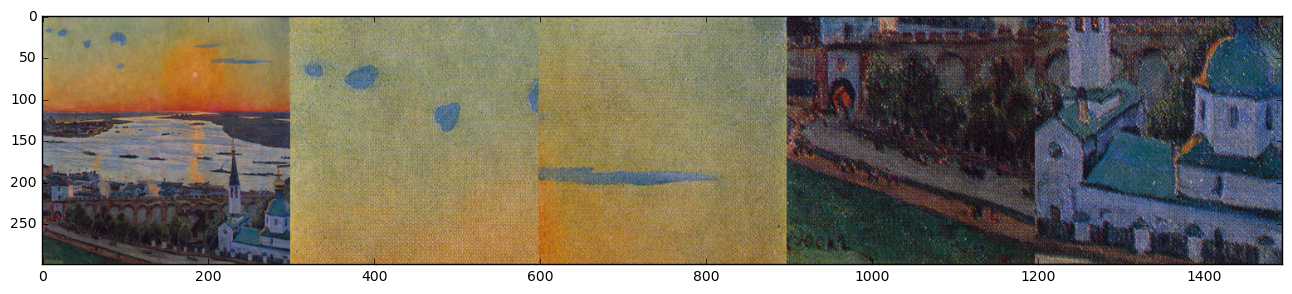

In [25]:
t, a, b, c, d = create_corner_crops('/datasets/kaggle/painters/train/222.jpg')

w = 299
n = Image.new('RGB', (w*5,w))
n.paste(t, (0, 0))
n.paste(a, (1*w, 0))
n.paste(b, (2*w, 0))
n.paste(c, (3*w, 0))
n.paste(d, (4*w, 0))

plt.figure(figsize=(16,8))
plt.imshow(n)

In [23]:
n.save('c.jpg')